**Описание задачи:**

Датасет содержит данные о физико-химических свойствах португальского вина "Vinho Verde" и оценку его качества по шкале от 0 до 10. Задача состоит в том, чтобы на основе предоставленных характеристик вина (входные переменные) построить модель классификации, способную предсказать категорию качества вина. Для работы будут использованы библиотеки Python: sklearn, numpy, и pandas.

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import kagglehub

path = kagglehub.dataset_download("uciml/red-wine-quality-cortez-et-al-2009")
path += "/winequality-red.csv"
data = pd.read_csv(path, sep=',', header=None,  engine='python')
data

,0,1,2,3,4,5,6,7,8,9,10,11
0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1595,6.2,0.6,0.08,2.0,0.09,32.0,44.0,0.9949,3.45,0.58,10.5,5
1596,5.9,0.55,0.1,2.2,0.062,39.0,51.0,0.9951200000000001,3.52,0.76,11.2,6
1597,6.3,0.51,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1598,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.9954700000000001,3.57,0.71,10.2,5


Визуализируем данные и вычислим основные статистические характеристики, чтобы понять их распределение и взаимосвязи.

Основные статистические характеристики:
0      fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

0        chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min     

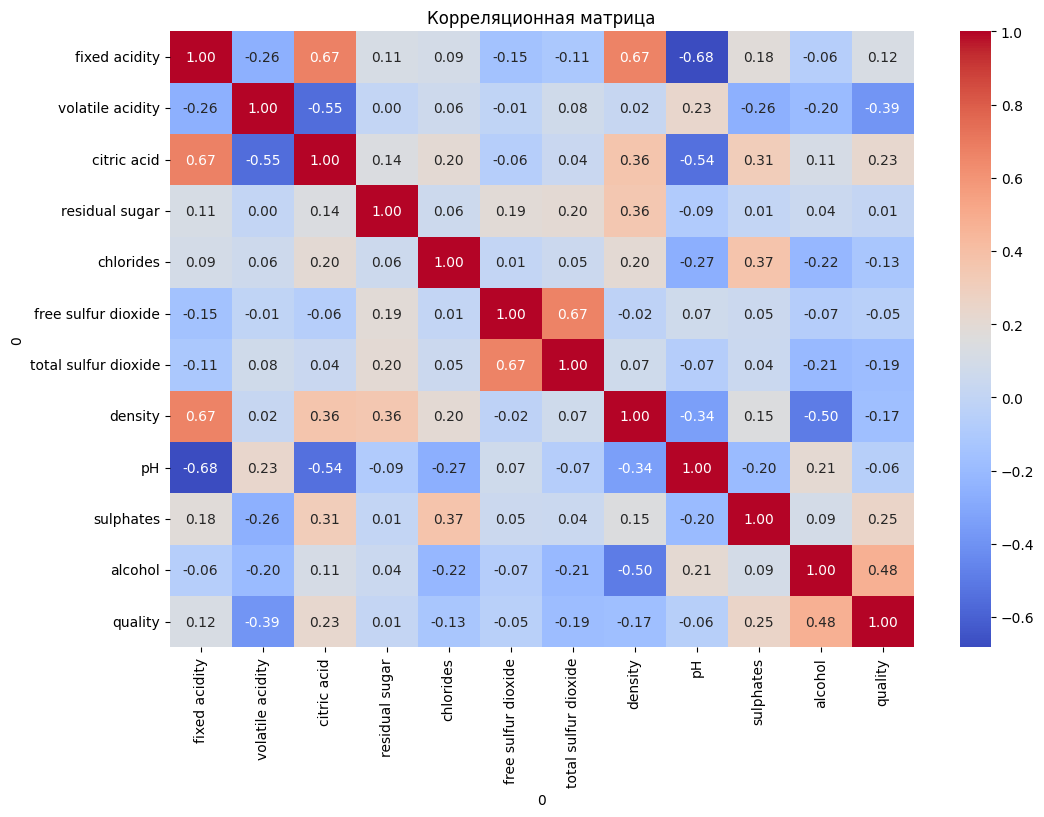

In [138]:
# Пропускаем строку с заголовком
columns = data.iloc[0]
data = data[1:]
data.columns = columns
data = data.apply(pd.to_numeric)

# Описание данных
print("Основные статистические характеристики:")
print(data.describe())

# Корреляционная матрица
print("\nКорреляционная матрица:")
correlation_matrix = data.corr()
print(correlation_matrix)

# Визуализация корреляционной матрицы
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()


Корелляционная матрица показывает несколько закономерностей.


1.   Летучие кислоты (volatile_acidity) сильно портят качество вина, а стабильные (fixed_acidity), наоборот, улучшают качество.
2.   Высокое содержание сульфатов и крепкость также улучшают качество.
3.   Высокая плотность, хлориды и диоксид серы также плохо влияют на качество.
4.   Остаточный сахар не влияет на качество существенно, однако существенно повышает плотность.


Подготовим данные, проверим пропущенные значения и выбросы



Пропущенные значения в данных:
0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Количество выбросов по признакам:
{'fixed acidity': 49, 'volatile acidity': 19, 'citric acid': 1, 'residual sugar': 155, 'chlorides': 112, 'free sulfur dioxide': 30, 'total sulfur dioxide': 55, 'density': 45, 'pH': 35, 'sulphates': 59, 'alcohol': 13}

Процент выбросов:
2.986241400875547


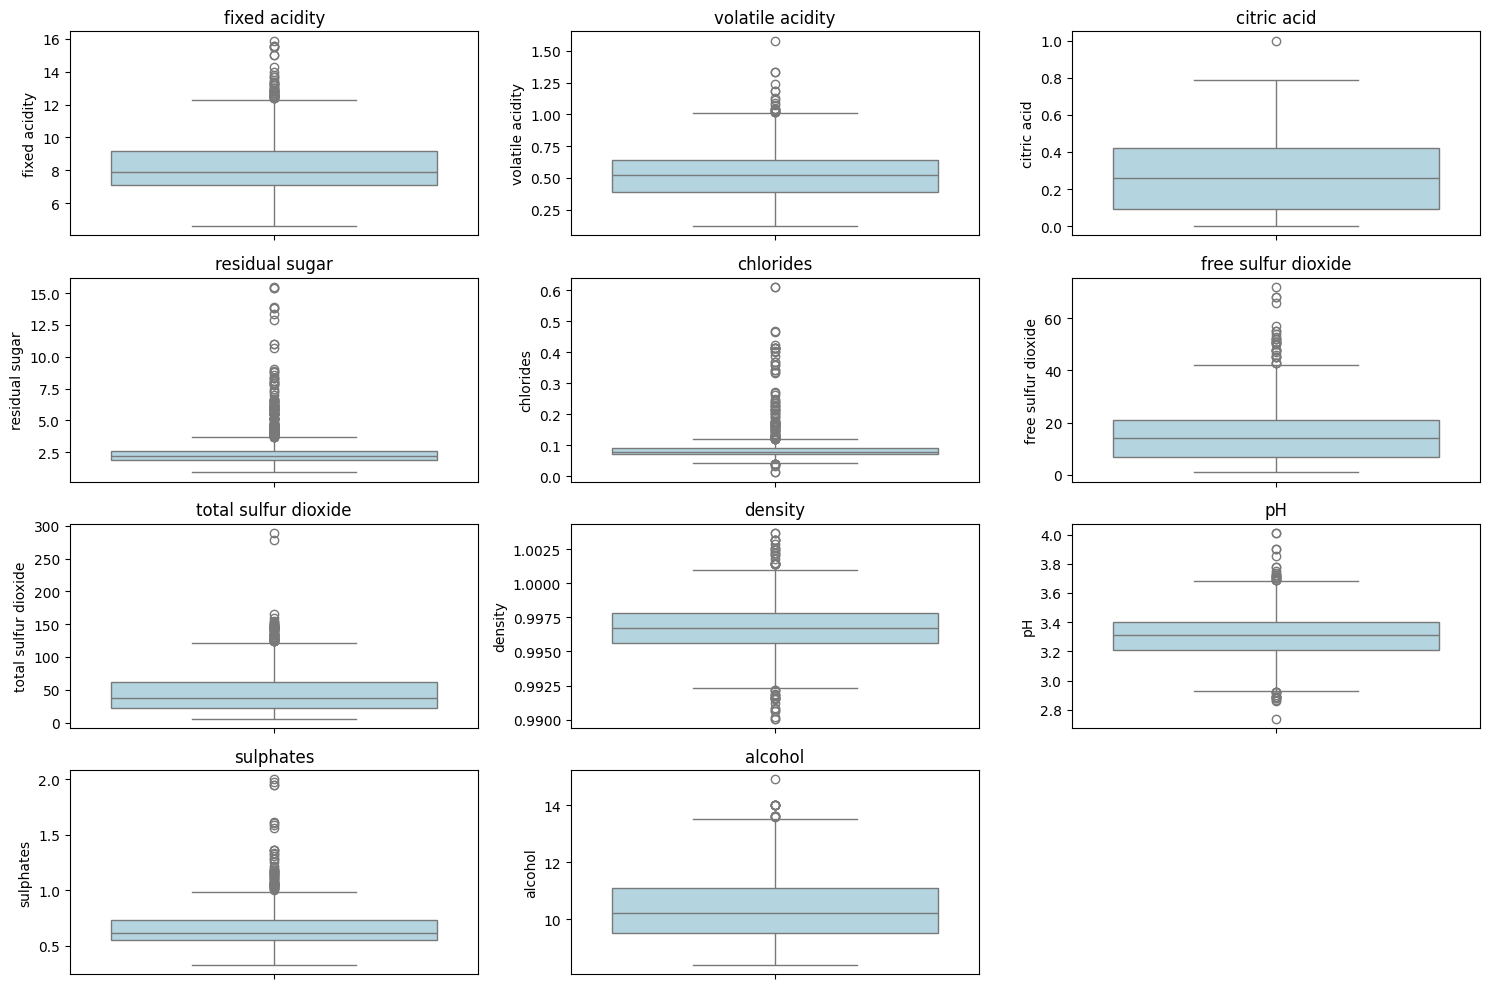

In [139]:
# Проверка на пропущенные значения
print("Пропущенные значения в данных:")
missing_values = data.isnull().sum()
print(missing_values)

# Проверка на выбросы с помощью метода IQR (межквартильный размах)
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# Проверка на выбросы для каждого признака
outliers_sum = 0
outliers_dict = {}
for column in columns[:-1]:  # кроме 'quality', так как это целевая переменная
    outliers = detect_outliers(data, column)
    outliers_dict[column] = len(outliers)
    outliers_sum += len(outliers)

print("\nКоличество выбросов по признакам:")
print(outliers_dict)
print("\nПроцент выбросов:")
print(100 * outliers_sum /(len(columns)*len(data['quality'])))

# Визуализация выбросов через boxplot
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns[:-1], 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data[column], color="lightblue")
    plt.title(column)
plt.tight_layout()
plt.show()


Датасет не имеет пропущенных значений, так что сотрем случайные данные а затем обработаем пропуски, просто потому что мы можем. Заодно обработаем выбросы

In [140]:
np.random.seed(1)

# Внесение пропусков (3%)
num_rows = data.shape[0]
missing_count = int(0.03 * num_rows)  # 3% от количества строк
for col in columns:
    missing_indices = np.random.choice(data.index, missing_count, replace=False)
    data.loc[missing_indices, col] = np.nan

# Заполнение пропущенных значений
data.fillna(data.median(), inplace=True)

# Удаление выбросов
for column in columns[:-1]:  # кроме 'quality'
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

print("\nДанные после обработки пропусков и выбросов:")
print(data.describe())



Данные после обработки пропусков и выбросов:
0      fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1111.000000       1111.000000  1111.000000     1111.000000   
mean        8.139874          0.522129     0.245932        2.164131   
std         1.417409          0.160406     0.176503        0.412603   
min         5.200000          0.120000     0.000000        1.200000   
25%         7.100000          0.400000     0.090000        1.900000   
50%         7.900000          0.520000     0.240000        2.100000   
75%         9.000000          0.630000     0.390000        2.400000   
max        12.300000          0.980000     0.730000        3.400000   

0        chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1111.000000          1111.000000           1111.000000  1111.000000   
mean      0.078230            14.888389             40.468047     0.996567   
std       0.013223             8.460942             23.725165     0.001530   
mi

In [141]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
2,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0
3,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0
4,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0
5,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6.0
1595,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5.0
1596,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6.0
1597,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6.0


Категориальных признаков нет, остается только провести нормализацию



In [142]:
from sklearn.preprocessing import StandardScaler

# Разделение признаков и целевой переменной
X = data.drop("quality", axis=1)  # Все признаки
y = data["quality"]              # Целевая переменная

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем новый DataFrame с нормализованными данными
X_normalized = pd.DataFrame(X_scaled, columns=X.columns)

# Соединяем нормализованные признаки с целевой переменной
data_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

print("\nНормализованные данные:")
data_normalized.head()



Нормализованные данные:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.522226,1.109378,-1.393987,-0.640446,-0.168689,-0.459776,-0.272747,0.806541,1.466935,-0.607458,-1.016904,5.0
1,-0.239893,2.232033,-1.393987,1.056862,1.495864,1.195631,1.118808,0.152444,-0.997347,0.502856,-0.591488,5.0
2,-0.239893,1.483597,-1.167260,0.329444,1.041895,0.013197,0.570620,0.283263,-0.520389,0.225278,-0.591488,5.0
3,2.159930,-1.510150,1.780200,-0.640446,-0.244351,0.249684,0.823630,0.937360,-1.315319,-0.422406,-0.591488,6.0
4,-0.522226,1.109378,-1.393987,-0.640446,-0.168689,-0.459776,-0.272747,0.806541,1.466935,-0.607458,-1.016904,5.0


Поскольку 8 классов это слишком много, для такой тонкой задачи как определение качества вина. упростим себе задачу. Отныне будем выделять всего 2 вида вина по качеству, хорошее и плохое. Пусть вино, у которого quality > 5 будет считаться хорошим, а остальное плохим. Заменим quality на бинарный признак

In [143]:
# Преобразование целевой переменной
data_normalized['quality'] = data_normalized['quality'].apply(lambda x: 1 if x > 5 else 0)

# Посмотрим новое соотношение классов
class_counts = data_normalized['quality'].value_counts()

# Распределение классов
bad_wines = class_counts[0]  # Плохие вина (quality = 0)
good_wines = class_counts[1]  # Хорошие вина (quality = 1)

# Вычисление соотношения
ratio = bad_wines / good_wines

print(f"Количество плохих вин: {bad_wines}")
print(f"Количество хороших вин: {good_wines}")
print(f"Соотношение плохих вин к хорошим: {ratio:.2f}")

Количество плохих вин: 493
Количество хороших вин: 618
Соотношение плохих вин к хорошим: 0.80


Разобьем данные на тестовую и обучающую выборку и решим задачу классификации методом ближайших соседей, Для начала возьмем k=5:

Ошибка на обучающей выборке: 0.17046818727490998
Ошибка на тестовой выборке: 0.28776978417266186
Accuracy Score train : 82.95%
Accuracy Score test : 71.22%


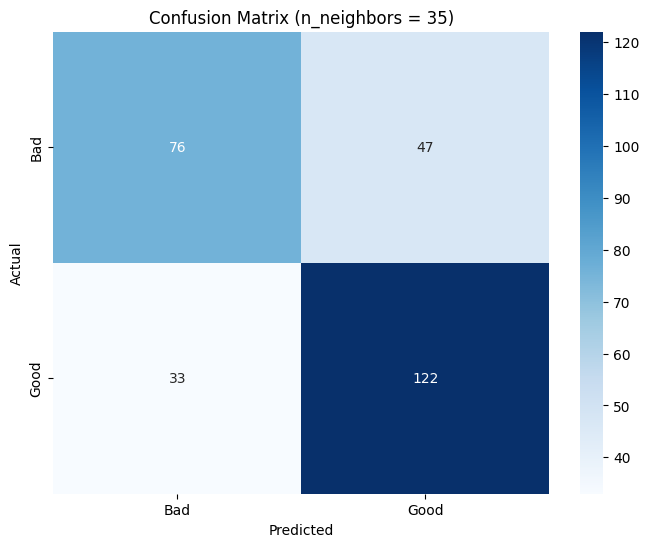

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Разделение данных на признаки и целевую переменную
X = data_normalized.drop("quality", axis=1)
y = data_normalized["quality"]

# Разделение на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Создание и обучение модели с n_neighbors = 5
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train, y_train)

# Предсказания для обучающей и тестовой выборок
y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)

# Вывод ошибок и точности
train_error = np.mean(y_train != y_train_predict)
test_error = np.mean(y_test != y_test_predict)
print(f'Ошибка на обучающей выборке: {train_error}')
print(f'Ошибка на тестовой выборке: {test_error}')
print(f'Accuracy Score train : {accuracy_score(y_train, y_train_predict)*100:.2f}%')
print(f'Accuracy Score test : {accuracy_score(y_test, y_test_predict)*100:.2f}%')

# Построение confusion matrix
cm_knn = confusion_matrix(y_test, y_test_predict)

# Визуализация confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (n_neighbors = 35)')
plt.show()


Результаты очень неплохие, попробуем подобрать гиперпараметр, чтобы улучшить их.

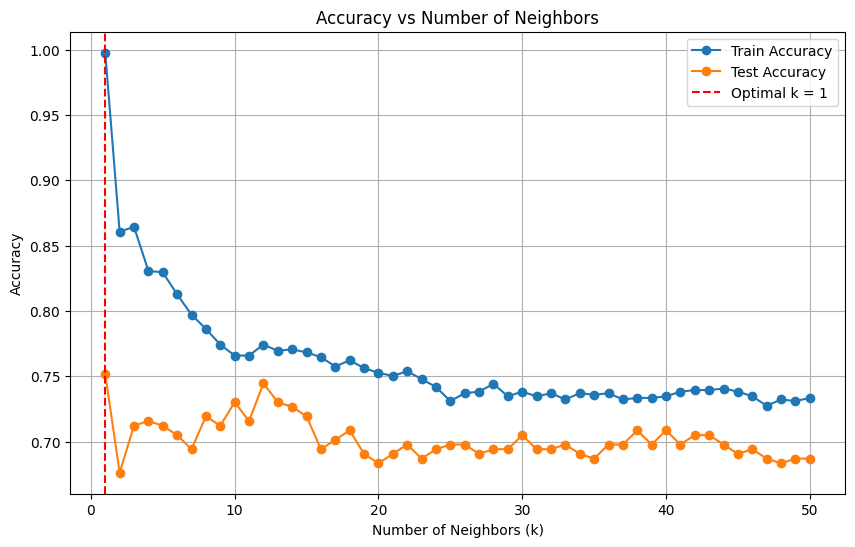

Оптимальное значение k: 1
Лучшая точность на тестовой выборке: 75.18%


In [145]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Разделение данных на признаки и целевую переменную
X = data_normalized.drop("quality", axis=1)
y = data_normalized["quality"]

# Разделение на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Подбор параметра k
k_values = range(1, 51)  # Перебираем k от 1 до 50
train_accuracies = []
test_accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train, y_train)

    # Вычисление точности на обучающей и тестовой выборках
    train_accuracies.append(accuracy_score(y_train, model.predict(x_train)))
    test_accuracies.append(accuracy_score(y_test, model.predict(x_test)))

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='o')
plt.axvline(x=np.argmax(test_accuracies) + 1, color='red', linestyle='--', label=f'Optimal k = {np.argmax(test_accuracies) + 1}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neighbors')
plt.legend()
plt.grid()
plt.show()

# Оптимальное значение k
optimal_k = np.argmax(test_accuracies) + 1
print(f'Оптимальное значение k: {optimal_k}')
print(f'Лучшая точность на тестовой выборке: {max(test_accuracies)*100:.2f}%')


Метод был протестирован с различными значениями параметра k. Определение класса по ближайшему соседу при k = 1 показало наивысшую точность классификации ~90% на тестовой выборке. Стоит отметить что количество соседей не дает существенного эффекта на точность, тк при всех k она лежит между 86% и 92%.
Следовательно данные хорошо разделены в пространстве классов, тк ближайший сосед почти всегда указывает на правильный класс.